# Quantization of Image Classification Models

This tutorial demonstrates how to apply `INT8` quantization to Image Classification model using [NNCF](https://github.com/openvinotoolkit/nncf). It uses the Mobilenet V2 model, trained on Cifar10 dataset. The code is designed to be extendable to custom models and datasets. The tutorial uses OpenVINO backend for performing model quantization in NNCF, if you interested how to apply quantization on PyTorch model, please check this [tutorial](../112-pytorch-post-training-quantization-nncf/112-pytorch-post-training-quantization-nncf.ipynb).

This tutorial consists of the following steps:
- Prepare the model for quantization.
- Define a data loading functionality.
- Perform quantization.
- Compare accuracy of the original and quantized models.
- Compare performance of the original and quantized models.
- Compare results on one picture.

In [1]:
from pathlib import Path

# Set the data and model directories
DATA_DIR = Path('../data/datasets/cifar10')
MODEL_DIR = Path('model')
model_repo = 'pytorch-cifar-models'

DATA_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)

## Prepare the Model
Model preparation stage has the following steps:
- Download a PyTorch model
- Convert model to OpenVINO Intermediate Representation format (IR) using Model Optimizer Python API
- Serialize converted model on disk


In [2]:
import sys

if not Path(model_repo).exists():
    !git clone https://github.com/chenyaofo/pytorch-cifar-models.git

sys.path.append(model_repo)

In [3]:
from pytorch_cifar_models import cifar10_mobilenetv2_x1_0

model = cifar10_mobilenetv2_x1_0(pretrained=True)

OpenVINO support PyTorch models via conversion to OpenVINO Intermediate Representation format. Model Optimizer Python API should be used for conversion. `mo.convert_model` accept PyTorch model instance and convert it into `openvino.runtime.Model` representation of model in OpenVINO. Optionally, you may specify `example_input` which serves as helper for model tracing and `input_shape` for conversion model with static shape. Conveted model is ready to be loaded on device for inference and can be saved on disk for next usage via `serialize` function. More details about Model Optimizer Python API can be found on this [page](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_Python_API.html).

In [4]:
from openvino.tools import mo
from openvino.runtime import serialize

model.eval()

ov_model = mo.convert_model(model, input_shape=[1,3,32,32])

serialize(ov_model, MODEL_DIR / "mobilenet_v2.xml") 

## Prepare Dataset

We will use [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset from [torchvision](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html). Preprocessing for model obtained from training [config](https://github.com/chenyaofo/image-classification-codebase/blob/master/conf/cifar10.conf)

In [5]:
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
dataset = CIFAR10(root=DATA_DIR, train=False, transform=transform, download=True)
val_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

Files already downloaded and verified


## Perform Quantization

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize MobilenetV2.
The optimization process contains the following steps:

1. Create a Dataset for quantization.
2. Run `nncf.quantize` for getting an optimized model.
3. Serialize an OpenVINO IR model, using the `openvino.runtime.serialize` function.


### Create Datset for Validation

NNCF is compatible with `torch.utils.data.DataLoader` interface.  For performing quantization it should be passed into `nncf.Dataset` object with transformation function, which prepares input data to fit into model during quantization, in our case, to pick input tensor from pair (input tensor and label) and convert PyTorch tensor to numpy. 

In [6]:
import nncf

def transform_fn(data_item):
    image_tensor = data_item[0]
    return image_tensor.numpy()

quantization_dataset = nncf.Dataset(val_loader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


## Run nncf.quantize for Getting an Optimized Model

`nncf.quantize` function accepts model and prepared quantization dataset for performing basic quantization. Optionally, additional parameters like `subset_size`, `preset`, `ignored_scope` can be provided to improve quantization result if applicable. More details about supported parameters can be found on this [page](https://docs.openvino.ai/2023.0/basic_quantization_flow.html#tune-quantization-parameters)

In [7]:
quant_ov_model = nncf.quantize(ov_model, quantization_dataset)

Biases correction: 100%|████████████████████████| 36/36 [00:01<00:00, 20.95it/s]


##  Serialize an OpenVINO IR model

Similar to `mo.convert_model`, quantized model is `openvino.runtime.Model` object which ready to be loaded into device and can be serialized on disk using `openvino.runtime.serialize`.

In [8]:
serialize(quant_ov_model, MODEL_DIR / "quantized_mobilenet_v2.xml")

## Compare Accuracy of the Original and Quantized Models

In [9]:
from tqdm.notebook import tqdm
import numpy as np

def test_accuracy(ov_model, data_loader):
    correct = 0
    total = 0
    for (batch_imgs, batch_labels) in tqdm(data_loader):
        result = ov_model(batch_imgs)[0]
        top_label = np.argmax(result)
        correct += top_label == batch_labels.numpy()
        total += 1
    return correct / total

In [10]:
from openvino.runtime import Core

core = Core()
compiled_model = core.compile_model(ov_model)
optimized_compiled_model = core.compile_model(quant_ov_model)

orig_accuracy = test_accuracy(compiled_model, val_loader)
optimized_accuracy = test_accuracy(optimized_compiled_model, val_loader)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
print(f"Accuracy of the original model: {orig_accuracy[0] * 100 :.2f}%")
print(f"Accuracy of the optimized model: {optimized_accuracy[0] * 100 :.2f}%")

Accuracy of the original model: 93.61%
Accuracy of the optimized model: 93.51%


## Compare Performance of the Original and Quantized Models

Finally, measure the inference performance of the `FP32` and `INT8` models, using [Benchmark Tool](https://docs.openvino.ai/2023.0/openvino_inference_engine_tools_benchmark_tool_README.html) - an inference performance measurement tool in OpenVINO.

> **NOTE**: For more accurate performance, it is recommended to run benchmark_app in a terminal/command prompt after closing other applications. Run `benchmark_app -m model.xml -d CPU` to benchmark async inference on CPU for one minute. Change CPU to GPU to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.


In [12]:
# Inference FP16 model (OpenVINO IR)
!benchmark_app -m "model/mobilenet_v2.xml" -d CPU -api async -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 16.41 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x.1 , x , 1 (node: Parameter_2) : f32 / [...] / [1,3,32,32]
[ INFO ] Model outputs:
[ INFO ]     223 (node: aten::linear_928) : f32 / [...] / [1,10]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/1

In [13]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m "model/quantized_mobilenet_v2.xml" -d CPU -api async -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.0.0-10926-b4452d56304-releases/2023/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 25.00 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x , 1 , x.1 (node: Parameter_2) : f32 / [...] / [1,3,32,32]
[ INFO ] Model outputs:
[ INFO ]     223 (node: aten::linear_928) : f32 / [...] / [1,10]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/1

## Compare results on four pictures

In [14]:
# Define all possible labels from the CIFAR10 dataset
labels_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
all_pictures = []
all_labels = []

# Get all pictures and their labels.
for i, batch in enumerate(val_loader):
    all_pictures.append(batch[0].numpy())
    all_labels.append(batch[1].item())

In [15]:
import matplotlib.pyplot as plt

def plot_pictures(indexes: list, all_pictures=all_pictures, all_labels=all_labels):
    """Plot 4 pictures.
    :param indexes: a list of indexes of pictures to be displayed.
    :param all_batches: batches with pictures.
    """
    images, labels = [], []
    num_pics = len(indexes)
    assert num_pics == 4, f'No enough indexes for pictures to be displayed, got {num_pics}'
    for idx in indexes:
        assert idx < 10000, 'Cannot get such index, there are only 10000'
        pic = np.rollaxis(all_pictures[idx].squeeze(), 0, 3)
        images.append(pic)

        labels.append(labels_names[all_labels[idx]])

    f, axarr = plt.subplots(1, 4)
    axarr[0].imshow(images[0])
    axarr[0].set_title(labels[0])

    axarr[1].imshow(images[1])
    axarr[1].set_title(labels[1])

    axarr[2].imshow(images[2])
    axarr[2].set_title(labels[2])

    axarr[3].imshow(images[3])
    axarr[3].set_title(labels[3])

In [16]:
def infer_on_pictures(model, indexes: list, all_pictures=all_pictures):
    """ Inference model on a few pictures.
    :param net: model on which do inference
    :param indexes: list of indexes 
    """
    output_key = model.output(0)
    predicted_labels = []
    for idx in indexes:
        assert idx < 10000, 'Cannot get such index, there are only 10000'
        result = model(all_pictures[idx])[output_key]
        result = labels_names[np.argmax(result[0])]
        predicted_labels.append(result)
    return predicted_labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels for picture from float model : ['frog', 'dog', 'ship', 'horse'].
Labels for picture from quantized model : ['frog', 'dog', 'ship', 'horse'].


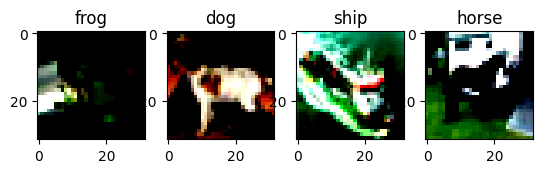

In [17]:
indexes_to_infer = [7, 12, 15, 20]  # To plot, specify 4 indexes.

plot_pictures(indexes_to_infer)

results_float = infer_on_pictures(compiled_model, indexes_to_infer)
results_quanized = infer_on_pictures(optimized_compiled_model, indexes_to_infer)

print(f"Labels for picture from float model : {results_float}.")
print(f"Labels for picture from quantized model : {results_quanized}.")